# Image and Video Processing 
## Project: Image Stegnography

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### Some basic useful functions 

In [65]:
def convertToGray(I):
    '''Converts an RGB image to grayscale image.'''
    if(len(I.shape)==2):
        return I
    I = 0.2126 * I[: , : , 0] + 0.7152 * I[: , : , 1] + 0.0722 * I[: , : , 2]
    I = np.round(I)
    I = I.astype(np.int64)
    return I

# Assuming I is I 256 gray levels.
def histogram(I):
    '''Computes the histogram of an I.'''
    hist = np.zeros(256)
    M, N = I.shape
    for i in range(M):
        for j in range(N): hist[I[i][j]] += 1
    
    return hist

def point_op(I, P = 1, L = 0, K = 255):
    '''Performs point operation on I.
    I: input image.
    P: scale factor.
    L: shift.
    K: maximum pixel value.'''
    P_new = P*I + L
    P_new = np.round(P_new)
    P_new = P_new.astype(np.int64)
    
    # clipping to 0 and 255
    P_new = np.maximum(P_new, 0) 
    P_new = np.minimum(P_new, K)
    
    return P_new

def FSCS(I):
    '''Performs Full Scale Contrast Stretching on I.
    I: input image.'''
    
    A = np.min(I)
    B = np.max(I)
    
    # as per results in class
    P = 255 / (B - A)
    L = -1 * A * 255 / (B - A)
    
    return point_op(I, P = P, L = L)

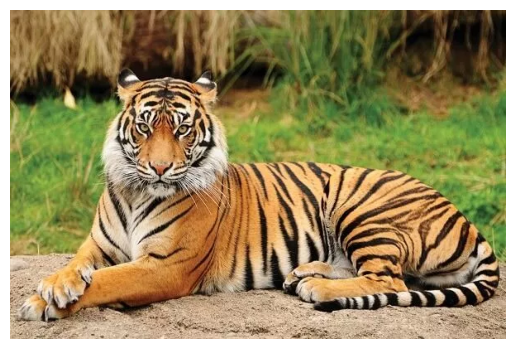

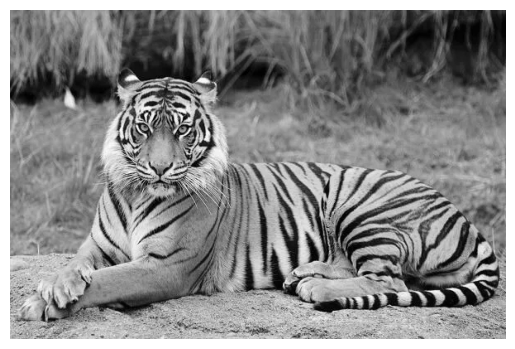

In [66]:
# import I
img = Image.open('Images/tiger.jpg')
img = np.asarray(img)

# convert to grayscale
gray_img = convertToGray(img)

# show I
plt.imshow(img)
plt.axis('off')
plt.show()

plt.imshow(gray_img, cmap='gray')
plt.axis('off')
plt.show()

# # show histogram
# hist = histogram(gray_img)

# plt.bar(np.arange(256), hist, color='black')
# plt.title('Histogram')
# plt.xlabel('Intensity Levels')
# plt.ylabel('Frequency')
# plt.show()

### (R, G, B) -> (L, a, b)

In [67]:
def transform(image):
    
    image = image / 255

    image[image > 0.04045] = ((image[image > 0.04045] + 0.055) / 1.055) ** 2.4
    image[image <= 0.04045] = image[image <= 0.04045] / 12.92
    image = image * 100
                
    return image

def linearTransform(image):
    m , n , p = image.shape
    new_image = np.zeros((m,n,p))
    
    X = 0.4124564 * image[:,:,0] + 0.3575761 * image[:,:,1] + 0.1804375 * image[:,:,2]
    Y = 0.2126729 * image[:,:,0] + 0.7151522 * image[:,:,1] + 0.0721750 * image[:,:,2]
    Z = 0.0193339 * image[:,:,0] + 0.1191920 * image[:,:,1] + 0.9503041 * image[:,:,2]
    
    X = X / 95.047
    Y = Y / 100.000
    Z = Z / 108.883
    
    X = np.where(X > 0.008856, X ** (1/3), 7.787 * X + 16/116)
    Y = np.where(Y > 0.008856, Y ** (1/3), 7.787 * Y + 16/116)
    Z = np.where(Z > 0.008856, Z ** (1/3), 7.787 * Z + 16/116)
    
    L = (116 * Y) - 16
    a = 500 * (X - Y)
    b = 200 * (Y - Z)
    
    new_image[:,:,0] = L
    new_image[:,:,1] = a
    new_image[:,:,2] = b
    
    return new_image

def convertToLAB(I):
    '''Converts an RGB image to LAB image.
    Input, I: RGB image.'''
    result = transform(I)
    result = linearTransform(I)
    result = FSCS(result)
    return result

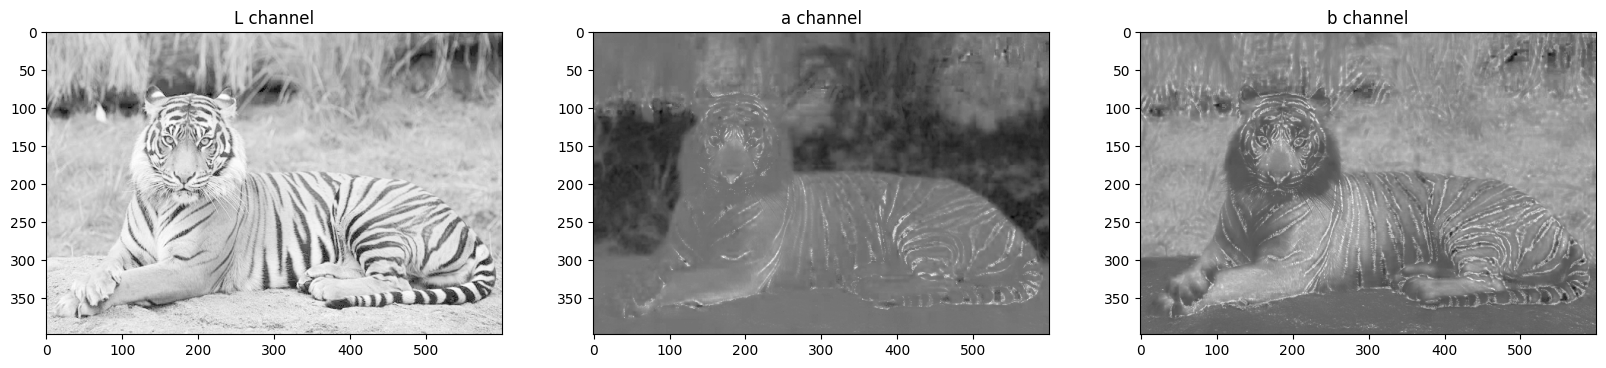

In [68]:
lgb_img = convertToLAB(img)

plt.figure(figsize=(20, 7))

plt.subplot(1, 3, 1)
plt.imshow(lgb_img[:,:,0], cmap='gray')
plt.title('L channel')

plt.subplot(1, 3, 2)
plt.imshow(lgb_img[:,:,1], cmap='gray')
plt.title('a channel')

plt.subplot(1, 3, 3)
plt.imshow(lgb_img[:,:,2], cmap='gray')
plt.title('b channel')

plt.show()

### DFT-IDFT Functions

In [82]:
def DFT(I, centered=False):
    '''Computes the 2D DFT of an image using matrix multiplication.
    Input: I, a 2D numpy array.
    Parameter centered: if True, the phase will be centered.
    Returns the magnitude and phase of the 2D DFT.'''
    M, N = I.shape
    
    I = I.copy()
        
    if(centered):
        for i in range(M):
            for j in range(N):
                I[i][j] *= (-1)**(i+j)
    
    # declaring matrices of complex exponential
    W_N = np.zeros([N,N], dtype=np.complex64)
    W_M = np.zeros([M,M], dtype=np.complex64)
    
    for u in range(N): 
        for i in range(N):
            W_N[u][i] = u*i
            
    for v in range(M): 
        for j in range(M):
            W_M[v][j] = v*j
    
    W_N = np.exp(-2*np.pi*1j/N) ** W_N
    W_M = np.exp(-2*np.pi*1j/M) ** W_M
    
    dft = np.matmul(np.matmul(W_M, I), W_N)
    
    return np.abs(dft), np.angle(dft)  

def IDFT(mag, phase, centered=False):
    '''Computes the 2D IDFT of an image.
    Input: mag, the magnitude of the 2D DFT.
           phase, the phase of the 2D DFT.
           centered: if True, origin will be conisdered at the center.
    Returns the 2D IDFT of the image using the IDFT matrix.'''
    I = mag * np.exp(1j * phase)
    M, N = I.shape
    
    # declaring matrices of complex exponential
    W_N = np.zeros([N,N], dtype=np.complex64)
    W_M = np.zeros([M,M], dtype=np.complex64)
    
    for u in range(N): 
        for i in range(N):
            W_N[u][i] = u*i
            
    for v in range(M): 
        for j in range(M):
            W_M[v][j] = v*j
    
    W_N = np.exp(2*np.pi*1j/N) ** W_N
    W_M = np.exp(2*np.pi*1j/M) ** W_M
    
    idft = np.matmul(np.matmul(W_M, I), W_N)
    idft = idft/(M*N)
    
    if(centered):
        for i in range(M):
            for j in range(N):
                idft[i][j] *= (-1)**(i+j)
    
    return np.real(idft) 

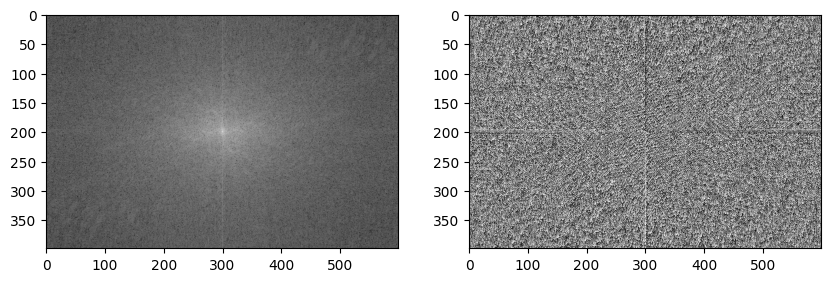

In [99]:
dft_mag, dft_phase = DFT(gray_img, centered=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.log(1 + dft_mag), cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(dft_phase, cmap='gray')
plt.show()


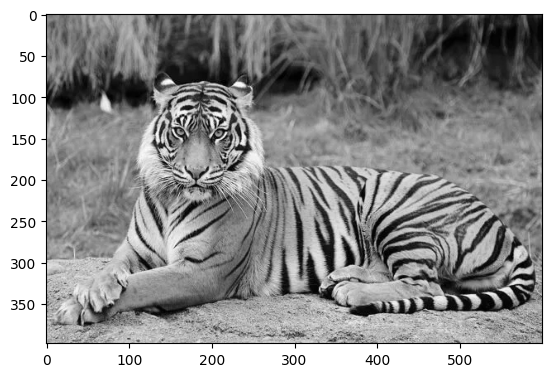

In [98]:
I = IDFT(dft_mag, dft_phase, centered=True)

plt.imshow(I, cmap='gray')
plt.show()